In [2]:
import pandas as pd
from Optimal_Stopping_Object import ModelConstructor  
import constants
import dill
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

import plot_functions as pf
import data_visualization as dv
from initializer import InitialThangs

wheel = dv.ColorWheel()
it = InitialThangs(experiment="Exp1")
plt.style.use('C:/Users/Seth Sullivan/anaconda3/Lib/site-packages/matplotlib/mpl-data/stylelib/cashaback_light.mplstyle')

In [3]:
input_keys = ["rt","rt_sd","mt","mt_sd","timing_sd",]
with open(r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\model_inputs\model_input_dict.pkl",'rb') as f:
    model_input_dict = dill.load(f)
true_parameters = [np.nanmedian(v) for k,v in model_input_dict.items() if "agent" not in k]
player_inputs = dict(zip(input_keys,true_parameters))

#* Comparison Targets load
with open(constants.MODEL_INPUT_PATH / 'participant_median_movement_onset_time.pkl','rb') as f:
    participant_median_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_sd_movement_onset_time.pkl','rb') as f:
    participant_sd_movement_onset_time = dill.load(f)
with open(constants.MODEL_INPUT_PATH / 'participant_wins.pkl','rb') as f:
    participant_wins = dill.load(f)  
participant_perc_wins = (participant_wins/it.num_trials)*100
with open(constants.MODEL_INPUT_PATH / 'participant_incorrects.pkl','rb') as f:
    participant_incorrects = dill.load(f)  
participant_perc_incorrects = (participant_incorrects/it.num_trials)*100

with open(constants.MODEL_INPUT_PATH / 'participant_indecisions.pkl','rb') as f:
    participant_indecisions = dill.load(f)  
participant_perc_indecisions = (participant_indecisions/it.num_trials)*100

In [4]:
model = ModelConstructor(
        experiment="Exp1",
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        agent_means=np.array([constants.agent_means, constants.agent_means])[:, :, np.newaxis],
        agent_sds=np.array([constants.agent_sds, constants.agent_sds])[:, :, np.newaxis],
        reaction_time=np.array([player_inputs["rt"], player_inputs["rt"]])[:, np.newaxis, np.newaxis],
        movement_time=np.array([player_inputs["mt"], player_inputs["mt"]])[:, np.newaxis, np.newaxis],
        reaction_sd=np.array([player_inputs["rt_sd"], player_inputs["rt_sd"]])[:, np.newaxis, np.newaxis],  
        movement_sd=np.array([player_inputs["mt_sd"], player_inputs["mt_sd"]])[:, np.newaxis, np.newaxis],
        timing_sd=np.array([[player_inputs['timing_sd']]*it.num_blocks, 
                            [player_inputs['timing_sd']-30]*it.num_blocks])[:, :, np.newaxis],
        guess_switch_delay=np.array([50.0, 0.0])[:, np.newaxis, np.newaxis], # These are being FIT, so copied models can just have them as 0
        guess_switch_sd=np.array([100.0, 0.0])[:, np.newaxis, np.newaxis],   
        electromechanical_delay=np.array([50.0, 50.0],dtype=float)[:, np.newaxis, np.newaxis],
        electromechanical_sd = np.array([0.0,0.0],dtype=float)[:, np.newaxis, np.newaxis],
        expected=True,  
        win_reward=1.0,
        incorrect_cost=0.0, 
        indecision_cost=0.0,
        round_num = 20,
        use_agent_behavior_lookup=False,

    )


In [5]:
models_to_plot = [model]
num_models = len(models_to_plot)

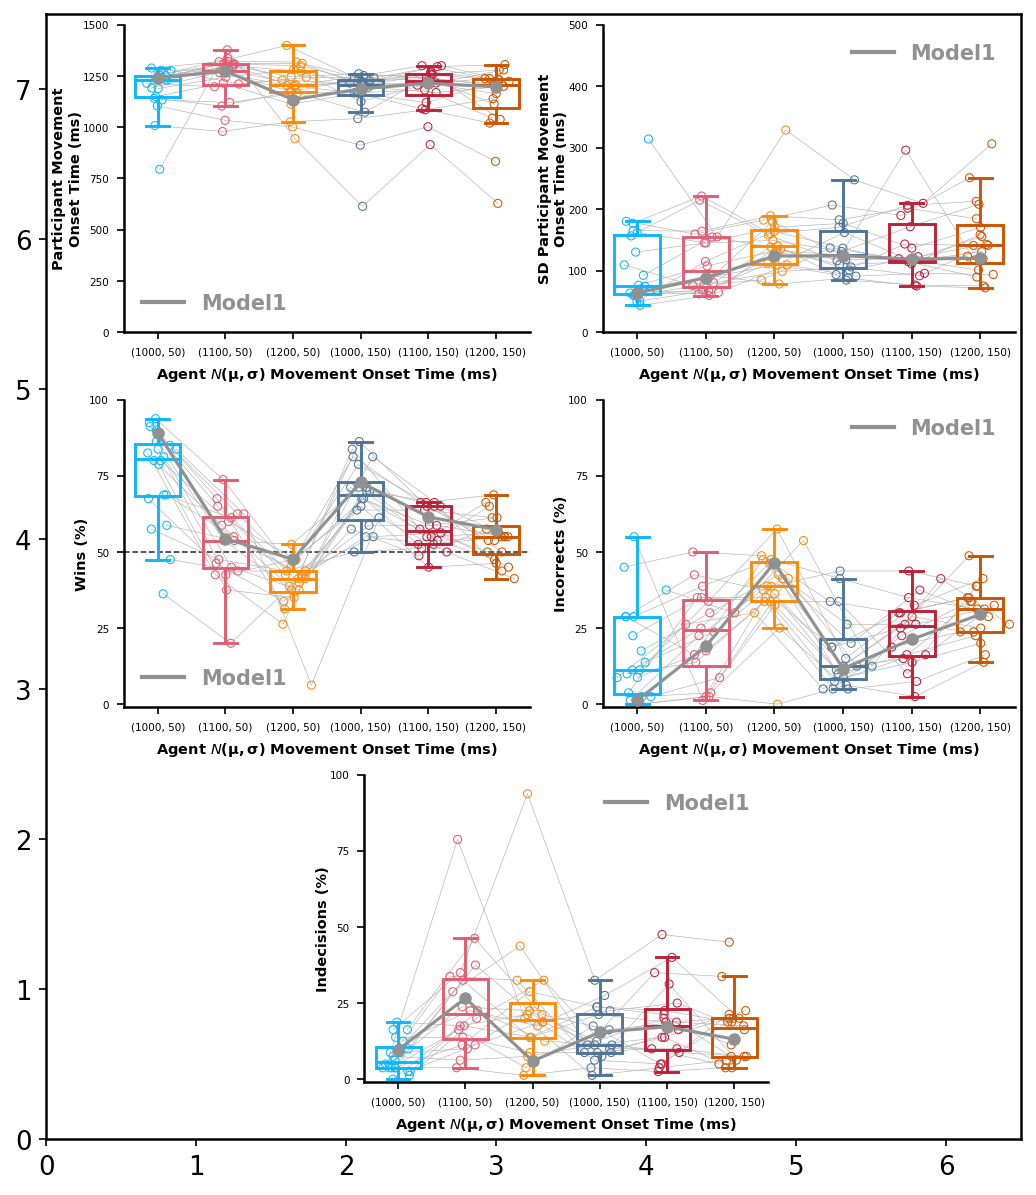

In [6]:

save_path = Path(
    r"D:\OneDrive - University of Delaware - o365\Desktop\MatchPennies-Agent-Expirement\results\figures"
)
w, h = 6.5, 7.5
bw = (0.35 * w) / it.num_blocks  # box widths of all boxes combined takes up 30% of the width
div_w = 2.3
xlocs = np.linspace(0, w / div_w, num=len(it.trial_block_titles))
legend_fontsize = 4.5
ticklabel_fontsize = 5
suptitle_fontsize = 6
label_fontsize = 7
markersize = 15

ylabelpad = 0

metrics = np.array(
    [
        participant_median_movement_onset_time,
        participant_sd_movement_onset_time,
        participant_perc_wins,
        participant_perc_incorrects,
        participant_perc_indecisions,
    ]
)[:, :, [0, 2, 4, 1, 3, 5]]  # Rearranging axes to get the order I want
ylocs = (
    [np.arange(0, 1501, 250)] + [np.arange(0, 501, 100)] + [np.arange(0, 101, 25)] * 3
)
ylabels = [
    "Participant Movement\nOnset Time (ms)",
    "SD Participant Movement\nOnset Time (ms)",
    "Wins (%)",
    # r"$\mathbf{\hat\theta}$",
    "Incorrects (%)",
    "Indecisions (%)",
]
ylims = [(0, 1500)] + [(0, 500)] + [(-1, 100)] * 3
#* Stat inset thangs
stat_heights = [16,3,1,1,1]
stat_ypos = [[575,575,100,], [250,250,400,],
             [11,11,1,31,31,21],
             [65,65,77,65,65,77],
             [50,50,61,50,50,61],
             ]
inset_ax_pos = [(0.1, 0.1, 0.45, 0.4),
                (0.105, 0.6, 0.45, 0.4)]
inset_xlims = [(0,1500),(0,500)]
inset_xlocs = np.linspace(1.5,3.5,num=3)
inset_ylocs = [np.arange(0,1501,500), np.arange(0,501,100)]
inset_ylims = [(0,1500), (0,500)]

model_labels = ["Base Model", "Optimal Model", "Suboptimal Model"]
# save_names = ["exp1_results_only_optimal_model", 'exp1_results_both_models','exp1_results_statistics',]
suptitles = ["Model Results", "Model Results", "Participant Behaviour"]
legend_locs = (0.58, 0.86)
mosaic = "aabb;ccdd;.ee."
fig = pf.NewFigure(mosaic, dpi=150, figsize=(w, h),wspace=None, hspace=None)
axs = list(fig.axes.values())
model_colors = [wheel.grey, wheel.dark_grey, wheel.black]
model_data = np.array([
    [model.results.get_metric(model.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal') for model in models_to_plot],
    [model.results.get_metric(model.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='optimal') for model in models_to_plot],
    [model.results.get_metric(model.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100 for model in models_to_plot],
    [model.results.get_metric(model.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100 for model in models_to_plot],
    [model.results.get_metric(model.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100 for model in models_to_plot],
])[:,:,[0, 2, 4, 1, 3, 5]] 
# figure_pvals = [exp1_pvals_df.query("Metric == 'Median_Movement_Onset_Time'"),
#                 exp1_pvals_df.query("Metric == 'SD_Movement_Onset_Time'"),
#                 exp1_pvals_df.query("Metric == 'Wins'"),
#                 exp1_pvals_df.query("Metric == 'Incorrects'"), 
#                 exp1_pvals_df.query("Metric == 'Indecisions'")
#                 ]
# figure_cles = [exp1_cles_df.query("Metric == 'Median_Movement_Onset_Time'"),
#                 exp1_cles_df.query("Metric == 'SD_Movement_Onset_Time'"),
#                 exp1_cles_df.query("Metric == 'Wins'"),
#                 exp1_cles_df.query("Metric == 'Incorrects'"), 
#                 exp1_cles_df.query("Metric == 'Indecisions'")
#                 ]

# * Looping axes for each metric
for i, ax in enumerate(axs):
    # * Looping each experimental condition
    for j in range(len(xlocs)):
        dv.boxplot(
            ax,
            xlocs[j],
            metrics[i, :, j],
            color=constants.xticklabel_colors_means[j],
            data_color=constants.xticklabel_colors_means[j],
            box_lw=1.4,
            box_width = bw,
        )

    dv.jitter_array(ax=ax,x_positions=xlocs,data=metrics[i,:,:].T,
                    data_color = constants.xticklabel_colors_means,
                    data_edge_color = wheel.lighten_color(wheel.light_grey,1.0),
                    noise_scale=0.06, include_mean = False, circle_size=markersize)

    if i == 2:
        ax.axhline(50, color=wheel.lighten_color(wheel.dark_grey,1.5), ls='--', zorder=-100, lw=0.75)
    ax.set_ylim(ylims[i])
    ax.set_xlim(min(xlocs) - 0.75*bw, max(xlocs) + 0.75*bw)
    ax.set_xticks(xlocs, labels=constants.xticklabels, fontsize=ticklabel_fontsize)
    ax.set_yticks(ylocs[i], labels=ylocs[i], fontsize=ticklabel_fontsize)
    ax.set_xlabel(it.xlabel, fontsize=label_fontsize)
    ax.set_ylabel(ylabels[i], fontsize=label_fontsize, labelpad=ylabelpad)
    
    pf.plot_models(ax,xlocs,data=model_data[i],line_colors=model_colors,
                   linestyles=['-']*num_models,legend_labels=['Model1'], legend_linewidth=2,
                   bw=bw, markersize=5)
    
# fig.add_all_letters(verticalshift=-0.05, horizontalshift=-0.01)
# fig.pad_fig(w_pad=-2,h_pad=0,w_space=-2,h_space=0.1)
# Reduce spacing between plots maek them all a bit wider
shift = -0.14
for ax_label in ["a","b","c", "d"]:
    if ax_label in ["b","d"]:
        fig.adjust_position(fig.axes[ax_label], (shift, 0)) # Shift the b and d plots to the left a bit
    fig.adjust_size(fig.axes[ax_label], (abs(shift), 0)) # Make the figures all a bit wider
# plt.subplots_adjust(right=0.8)
# plt.subplot_tool()
# fig.axmain.patch.set_facecolor('white')
plt.show()
# fig.savefig(SAVE_PATH / "exp1_data_panel.png",transparent=True)